In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import modelUtils

import matplotlib.pyplot as plt # For data viz
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)

System Version: 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
PyTorch version 2.3.1
Torchvision version 0.18.1
Numpy version 1.24.3


In [36]:
IMAGE_DIRECTORY = 'images'
TRAIN_SIZE = 0.8
SEED = 5111997
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15
WEIGHT_DECAY = 1e-3
torch.manual_seed(SEED)

In [37]:
#Loading in dataset and converting dataset to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(1)
])

full_dataset = modelUtils.PositionDataset(IMAGE_DIRECTORY, transform)
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
#Creating the training loop
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
train_losses, validation_losses = [], []
model = modelUtils.PositionClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(validation_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    validation_loss = running_loss / len(validation_loader.dataset)
    validation_losses.append(validation_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train loss: {train_loss}, Validation loss: {validation_loss}")


Device:  cuda


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1/15 - Train loss: 0.794660023645006, Validation loss: 0.7388753438956785


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/15 - Train loss: 0.681793655833821, Validation loss: 0.6652499052505325


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/15 - Train loss: 0.6375758405810457, Validation loss: 0.7264236329322971


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4/15 - Train loss: 0.6124062209213856, Validation loss: 0.6190214220005439


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/15 - Train loss: 0.5955881554882191, Validation loss: 0.5990710802373662


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 6/15 - Train loss: 0.5821601705437776, Validation loss: 0.6168975561396755


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 7/15 - Train loss: 0.5695792161618292, Validation loss: 0.5837224460439722


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 8/15 - Train loss: 0.560837793200383, Validation loss: 0.5910618563039082


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 9/15 - Train loss: 0.5511736753146446, Validation loss: 0.5997736220884587


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 10/15 - Train loss: 0.5432595403812521, Validation loss: 0.5645309122802437


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 11/15 - Train loss: 0.535139926050893, Validation loss: 0.5805309133992457


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 12/15 - Train loss: 0.5281265332570458, Validation loss: 0.5754383094960841


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 13/15 - Train loss: 0.521770684333459, Validation loss: 0.5728322001980378


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 14/15 - Train loss: 0.5126432210252808, Validation loss: 0.5781284846975312


Training loop:   0%|          | 0/5000 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 15/15 - Train loss: 0.5064662690609532, Validation loss: 0.5744710865572241


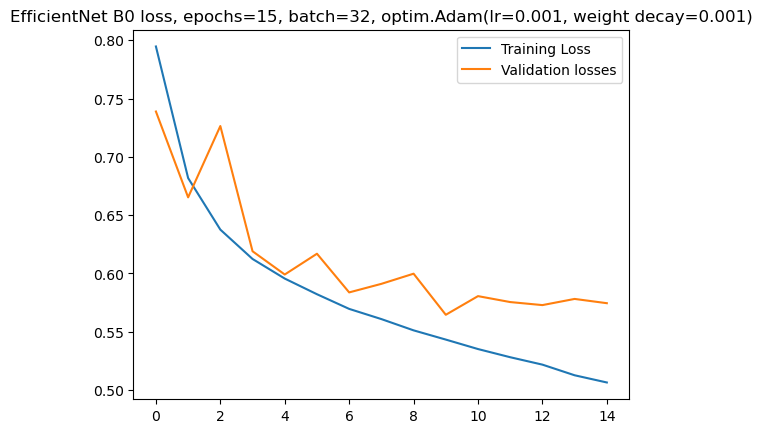

In [42]:
#Graph
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation losses")
plt.legend()
plt.title(f"EfficientNet B0 loss, epochs={NUM_EPOCHS}, batch={BATCH_SIZE}, optim.Adam(lr={LEARNING_RATE}, weight decay={WEIGHT_DECAY})")
plt.show()

In [40]:
model_path = f"models/efficientnet_b0_{NUM_EPOCHS}epochs_{BATCH_SIZE}batch_{LEARNING_RATE}lr_{WEIGHT_DECAY}weightdecay.pth"
torch.save(model.state_dict(), model_path)

In [41]:
#testing model accuracy
model_path = f"models/efficientnet_b0_{NUM_EPOCHS}epochs_{BATCH_SIZE}batch_{LEARNING_RATE}lr_{WEIGHT_DECAY}weightdecay.pth"
model = modelUtils.PositionClassifier()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
num_correct = 0
with torch.no_grad():
    for images, labels in tqdm(validation_loader, desc='Validation loop'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        for i in range(len(outputs)):
            if torch.argmax(outputs[i]) == labels[i]:
                num_correct += 1
print(num_correct / len(validation_dataset))


Validation loop:   0%|          | 0/1250 [00:00<?, ?it/s]

0.7608130406520326
